<a href="https://colab.research.google.com/github/docuracy/desCartes/blob/main/experiments/SegFormer-b4-masked-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount Google Drive; install dependencies
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install opencv-python
!pip install --upgrade torch_xla torch
!pip install evaluate
!pip install wandb -qU
!pip install torchmetrics

In [ ]:
#@title Downgrade Package for Compatibility (required when continuing training if package has been updated)

# !pip uninstall -y transformers
# !pip install transformers==4.49.0


In [ ]:
# @title Load SegmentationDatasets from Drive { display-mode: "code" }

import torch
import json

sample = False # @param {type:"boolean"}

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

torch.serialization.add_safe_globals([SegmentationDataset])

# Load the dataset from a binary file
def load_dataset(file_path):
    dataset = torch.load(file_path)
    print(f"Dataset loaded from {file_path}")

    # Check if the dataset is a SegmentationDataset
    if isinstance(dataset, SegmentationDataset):
        print(f"Dataset contains {len(dataset)} samples.")

        # Reduce dataset size to 10% if sample=True
        if sample:
            reduced_size = max(4, int(len(dataset) * 0.1))  # Ensure at least 4 samples
            dataset.data = dataset.data[:reduced_size]
            print(f"Reduced dataset size: {len(dataset)} samples.")

        # Iterate through the data and print the type and shape of the first sample
        first_sample = dataset[0]
        if isinstance(first_sample, torch.Tensor):
            print(f"First sample shape: {first_sample.shape}")
        else:
            print(f"First sample: {first_sample}")

    else:
        print("Loaded data is not an instance of SegmentationDataset.")

    return dataset

# Define file paths for loading
train_data_path = f'/content/drive/MyDrive/desCartes/pytorch/train_dataset.pt'
eval_data_path = f'/content/drive/MyDrive/desCartes/pytorch/eval_dataset.pt'

# Load the datasets from Google Drive
eval_dataset = load_dataset(eval_data_path)
train_dataset = load_dataset(train_data_path)


Dataset loaded from /content/drive/MyDrive/desCartes/pytorch/eval_dataset.pt
Dataset contains 984 samples.
First sample: {'pixel_values': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1300, 0.1100, 0.0500,  ..., 0.0000, 0.0000, 0.0000],
         [0.0800, 0.0900, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0800, 0.0400, 0.0700,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0100, 0.0000, 0.0200,  ..., 0.0100, 0.0100, 0.0100],
         [0.0200, 0.0200, 0.0100,  ..., 0.0000, 0.0000, 0.0200],
         [0.0200, 0.0500, 0.0300,  ..., 0.0100, 0.0100, 0.0300],
         ...,
         [0.1200, 0.1600, 0.1200,  ..., 0.0000, 0.0000, 0.0000],
         [0.1800, 0.2500, 0.1700,  ..., 0.0000, 0.0000, 0.0000],
         [0.1700, 0.1600, 0.2200,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.

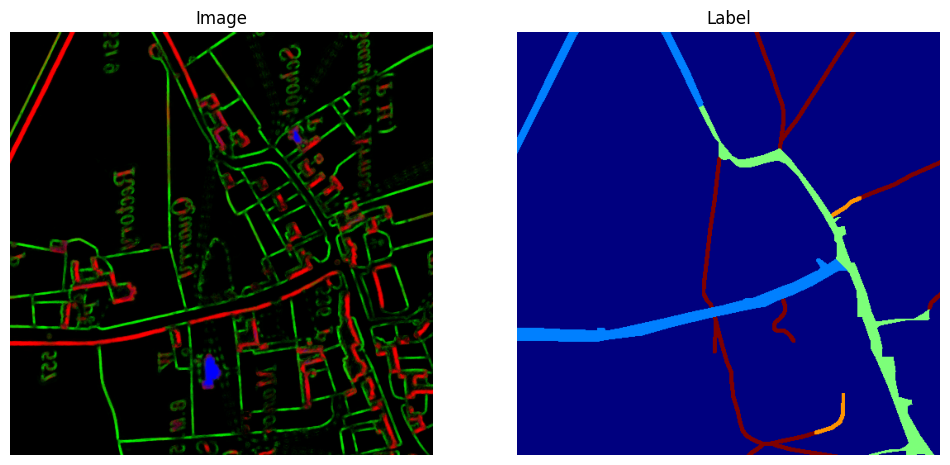

In [ ]:
# @title Display Random Sample { display-mode: "code" }

import random
import matplotlib.pyplot as plt

# Function to show a random sample of image and label
def show_random_sample(dataset):
    # Select a random index
    idx = random.randint(0, len(dataset) - 1)  # Use len(dataset) instead of len(dataset['images'])

    # Get the image and label corresponding to the random index
    sample = dataset[idx]  # This will be a dictionary
    image = sample['pixel_values']  # Access 'pixel_values' key
    label = sample['labels']  # Access 'labels' key

    # Ensure the image is in the correct format (CHW -> HWC)
    image = image.permute(1, 2, 0).numpy()

    # Set up the figure for side-by-side display
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Show the image
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis("off")

    # Show the label with a custom colormap
    axes[1].imshow(label.numpy(), cmap='jet', vmin=0, vmax=4)  # Adjust colormap as needed
    axes[1].set_title("Label")
    axes[1].axis("off")

    plt.show()

# Show a random sample from the eval dataset
show_random_sample(eval_dataset)

# Alternatively, you can show a random sample from the train dataset:
# show_random_sample(train_dataset)


In [ ]:
# @title Safe Intersection-over-Union { display-mode: "code" }

from typing import Dict, Optional

import datasets
import numpy as np

import evaluate

def clip_round(value, decimals=5):
    """
    Efficient rounding that avoids precision issues near 0 and 1.
    """
    eps = 10 ** -decimals  # Calculate epsilon
    rounded_value = np.round(value, decimals)

    if np.isscalar(rounded_value):
        return 1.0 if rounded_value >= 1 - eps else (0.0 if rounded_value <= eps else rounded_value)

    rounded_value[rounded_value >= 1 - eps] = 1.0
    rounded_value[rounded_value <= eps] = 0.0
    return rounded_value

def intersect_and_union(
    pred_label,
    label,
    num_labels,
    ignore_index
):
    """
    Computes the intersection and union of predictions and labels.
    """
    if ignore_index >= 0:
        mask = label != ignore_index
        pred_label, label = pred_label[mask], label[mask]

    intersect = pred_label[pred_label == label]

    area_intersect = np.histogram(intersect, bins=num_labels, range=(0, num_labels - 1))[0].astype(np.uint32)
    area_pred_label = np.histogram(pred_label, bins=num_labels, range=(0, num_labels - 1))[0].astype(np.uint32)
    area_label = np.histogram(label, bins=num_labels, range=(0, num_labels - 1))[0].astype(np.uint32)

    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label

def total_intersect_and_union(
    results,
    gt_seg_maps,
    num_labels,
    ignore_index
):
    """
    Accumulates intersection and union over all samples.
    """
    total_area_intersect = np.zeros(num_labels, dtype=np.uint32)
    total_area_union = np.zeros(num_labels, dtype=np.uint32)
    total_area_pred_label = np.zeros(num_labels, dtype=np.uint32)
    total_area_label = np.zeros(num_labels, dtype=np.uint32)

    for result, gt_seg_map in zip(results, gt_seg_maps):
        area_intersect, area_union, area_pred_label, area_label = intersect_and_union(
            result, gt_seg_map, num_labels, ignore_index
        )
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

    return total_area_intersect, total_area_union, total_area_pred_label, total_area_label


def iou(
    results,  # pred_labels (the predicted class indices)
    gt_seg_maps,  # labels (the ground truth class indices)
    num_labels,  # The total number of classes in the segmentation task
    ignore_index,
    nan_to_num=None,
):
    """
    Computes per-category and overall IoU.
    """
    total_area_intersect, total_area_union, total_area_pred_label, total_area_label = total_intersect_and_union(
        results, gt_seg_maps, num_labels, ignore_index
    )

    eps = 1e-10
    round_decimals = 5

    total_label_sum = total_area_label.sum()  # Store sum to avoid redundant computations

    all_acc = np.clip(total_area_intersect.sum() / (total_label_sum + eps), eps, 1 - eps)
    iou = np.clip(total_area_intersect / (total_area_union + eps), eps, 1 - eps)

    all_acc = clip_round(all_acc, round_decimals)
    iou = clip_round(iou, round_decimals)

    # Assign IoU = 1 for empty classes
    iou[total_area_label == 0] = 1.0

    # Set ignored index to 0
    if ignore_index >= 0:
        iou[ignore_index] = 0.0

    metrics = {"overall_accuracy": all_acc, "per_category_iou": iou}

    if nan_to_num is not None:
        metrics = {k: np.nan_to_num(v, nan=nan_to_num) for k, v in metrics.items()}

    return metrics

In [ ]:
# @title Train Model { display-mode: "code" }

# if 'iou' not in globals():
#     raise NameError("Function 'mean_iou' is not defined. Run the appropriate cell first.")

if 'train_dataset' not in globals() or 'eval_dataset' not in globals():
    raise NameError("Either 'train_dataset' or 'eval_dataset' is not defined. Run the appropriate cell first.")

if not train_dataset:  # Checks if train_dataset is empty
    raise ValueError("'train_dataset' is empty.")

if not eval_dataset:  # Checks if eval_dataset is empty
    raise ValueError("'eval_dataset' is empty.")

print("All variable checks passed! Proceeding with execution.")

# Import necessary libraries
import os
import sys
import shutil
import numpy as np
import gc
import time
import math
import wandb
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.runtime as xr
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch_xla.distributed.parallel_loader as pl
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, SequentialLR
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor, TrainingArguments, Trainer, EarlyStoppingCallback
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support
from google.colab import userdata

# Google Drive Path Configuration
project_path = '/content/drive/MyDrive/desCartes'
model_path = f'{project_path}/models'
results_path = f'{project_path}/results'

# Select Model (must match image size of samples)
# Original Publication: https://github.com/NVlabs/SegFormer/tree/master/local_configs/segformer
# Hugging Face: https://huggingface.co/models?search=nvidia%20/%20segformer
# Largest model which can be trained with Colab TPU v2-4 memory limit is b4 (512 x 512): ~75% capacity at batch size of 2
model_version = 'b4'
restart_training = True # @param {type:"boolean"}
checkpoint_number = 0 # @param {type: "integer"}

class_weights_path = f'/content/drive/MyDrive/desCartes/models/class_weights.json'

# Define class labels
class_labels = ["background", "main_road", "minor_road", "semi_enclosed_path", "unenclosed_path"]

# Local directory for storing dataset
local_data_dir = "/content/data"

# Training Configuration: by trial and error, these are found to be the maximum that can be accommodated without TPU stalling
per_device_train_batch_size = 2  # Batch size for training
per_device_eval_batch_size = per_device_train_batch_size

# Number of workers used by DataLoaders
num_workers = 4
persistent_workers = num_workers > 0

# Raising the following radically increases training time: unnecessary as 8x TPUs effectively multiply the batch size
gradient_accumulation_steps = 1  # Simulates a batch size of gradient_accumulation_steps * per_device_train_batch_size

# Loss Function Configuration
loss_gamma = 1.5  # Focal loss gamma
# loss_alpha = 0.40  # Focal loss alpha (now handled automatically)
dice_weight = 0.6
loss_weight = 1 - dice_weight

###################################################

!wandb --version
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_TOKEN')
!wandb login
wandb.init(project="tpu-segmentation", name=f"TPU-Training-{model_version}", settings=wandb.Settings(_service_wait=60))

hf_token = userdata.get('HF_TOKEN')

# Configure label mappings
num_classes = len(class_labels)
id2label = {i: label for i, label in enumerate(class_labels)}
label2id = {label: i for i, label in id2label.items()}

# Load class weights from JSON
with open(class_weights_path, 'r') as f:
    weights_dict = json.load(f)
CLASS_WEIGHTS_NP = [weights_dict[str(i)] for i in range(len(weights_dict))]
# Apply smoothing
CLASS_WEIGHTS_NP = np.log(1.1 + CLASS_WEIGHTS_NP)
# Normalise back
CLASS_WEIGHTS_NP /= CLASS_WEIGHTS_NP.sum()
class_weights = torch.tensor(
    CLASS_WEIGHTS_NP,
    dtype=torch.bfloat16 # Consistent with TrainingArguments
)
print(f"Class weights loaded: {CLASS_WEIGHTS_NP}")

# Test for existing checkpoints
checkpoint_path = f"{model_path}/checkpoints/{model_version}"

"""
This codeblock simply removes any checkpoints greater than the given value, which
may be necessary if the last training run crashed before all the required files
had been saved. It also allows for rewinding training.
"""
if checkpoint_number > 0 and os.path.exists(f"{checkpoint_path}/checkpoint-{checkpoint_number}"):
    # Delete checkpoint directories with greater indices
    if os.path.exists(checkpoint_path):
        for checkpoint_dir in os.scandir(checkpoint_path):
            # Check if the item is a directory and starts with 'checkpoint-'
            if checkpoint_dir.is_dir() and checkpoint_dir.name.startswith("checkpoint-"):
                current_checkpoint_number = int(checkpoint_dir.name.split("-")[1])
                if current_checkpoint_number > checkpoint_number:
                    # Delete the directory
                    shutil.rmtree(checkpoint_dir.path)
else:
    if checkpoint_number > 0:
        # Stop execution if the desired checkpoint doesn't exist
        print(f"Checkpoint {checkpoint_number} does not exist. Stopping execution.")
        sys.exit(1)

    if restart_training and os.path.exists(checkpoint_path):
        # Delete the folder and its contents if restarting training
        shutil.rmtree(checkpoint_path)
        os.makedirs(checkpoint_path)  # Recreate the empty checkpoint directory

# Set the checkpoint to the latest remaining one (if any exists)
checkpoint = os.path.exists(checkpoint_path) and any(os.scandir(checkpoint_path))

def load_or_download_segformer():
    try:
        model_name = f"nvidia/segformer-{model_version}-finetuned-ade-512-512"
        base_model_path = f'{model_path}/base/{model_name}'

        if not os.path.exists(base_model_path):
            print(f"Downloading model from Hugging Face: {model_name}")
            os.makedirs(base_model_path)

            if hf_token:
                os.environ["HF_TOKEN"] = hf_token

            model = SegformerForSemanticSegmentation.from_pretrained(
                model_name,
                num_labels=num_classes,
                id2label=id2label,
                label2id=label2id,
                ignore_mismatched_sizes=True,
            )
            model.save_pretrained(base_model_path)
        else:
            model = SegformerForSemanticSegmentation.from_pretrained(base_model_path)

        return model
    except Exception as e:
        print(f"Error loading/downloading: {e}")
        raise

def compute_metrics(eval_pred, batch_size=16):
    ignore_index = -1
    logits, labels = eval_pred
    num_samples = logits.shape[0]

    all_metrics = {
        "overall_accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "weighted_mean_iou": [],
    }
    per_category_ious = [[] for _ in range(num_classes)]

    try:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)

            # Use uint8 for labels since the values range 0-4
            batch_logits = torch.from_numpy(logits[start_idx:end_idx]).cpu()  # Offload early
            batch_labels = labels[start_idx:end_idx].astype(np.uint8)  # Ensure efficient storage

            with torch.no_grad():
                logits_tensor = nn.functional.interpolate(
                    batch_logits, size=batch_labels.shape[-2:], mode="nearest"
                ).argmax(dim=1).numpy().astype(np.uint8)  # Convert to uint8

            batch_metrics = iou(
                results=logits_tensor,
                gt_seg_maps=batch_labels,
                num_labels=num_classes,
                ignore_index=ignore_index,
            )

            all_metrics["overall_accuracy"].append(
                np.float32(batch_metrics["overall_accuracy"])
            )
            per_category_iou = batch_metrics["per_category_iou"]

            pred_flat = logits_tensor.ravel()  # Use ravel() instead of flatten() to avoid copies
            labels_flat = batch_labels.ravel()  # Same here

            precision, recall, f1, _ = precision_recall_fscore_support(
                labels_flat, pred_flat, average="weighted", zero_division=0
            )

            all_metrics["precision"].append(np.float32(precision))
            all_metrics["recall"].append(np.float32(recall))
            all_metrics["f1_score"].append(np.float32(f1))

            for i, v in enumerate(per_category_iou):
                if i != ignore_index:
                    per_category_ious[i].append(np.float32(v))

            gc.collect()  # Explicit garbage collection to free memory

        # Compute final metrics
        all_metrics["overall_accuracy"] = np.mean(all_metrics["overall_accuracy"], dtype=np.float32).item()
        all_metrics["precision"] = np.mean(all_metrics["precision"], dtype=np.float32).item()
        all_metrics["recall"] = np.mean(all_metrics["recall"], dtype=np.float32).item()
        all_metrics["f1_score"] = np.mean(all_metrics["f1_score"], dtype=np.float32).item()

        final_per_category_ious = [np.mean(ious, dtype=np.float32).item() for ious in per_category_ious]

        for i, v in enumerate(final_per_category_ious):
            if i != ignore_index:
                all_metrics[f"iou_{id2label[i]}"] = v

        all_metrics["unweighted_mean_roads_iou"] = (
            (final_per_category_ious[1] + final_per_category_ious[2]) / 2
        )
        all_metrics["unweighted_mean_paths_iou"] = (
            (final_per_category_ious[3] + final_per_category_ious[4]) / 2
        )
        all_metrics["unweighted_mean_iou"] = np.average(final_per_category_ious).item()

        if ignore_index >= 0:
            reduced_class_weights = np.delete(CLASS_WEIGHTS_NP, ignore_index)
        else:
            reduced_class_weights = CLASS_WEIGHTS_NP

        all_metrics["weighted_mean_iou"] = np.average(
            final_per_category_ious, weights=reduced_class_weights
        ).item()

        return all_metrics

    except Exception as e:
        print(f"Error in compute_metrics: {e}")
        return {
            "error": True,
            "overall_accuracy": 0.0,
            "weighted_mean_iou": 0.0,
            "precision": 0.0,
            "recall": 0.0,
            "f1_score": 0.0,
            **{f"iou_{id2label[i]}": 0.0 for i in range(num_classes)},
        }

def tpu_worker_process(rank):

    try:
        # Set TPU device
        device = xm.xla_device()
        world_size = xr.world_size()

        # Calculate effective batch size (across all TPUs)
        effective_batch_size = per_device_train_batch_size * world_size * gradient_accumulation_steps
        # Calculate steps per epoch (without dropping the last batch)
        steps_per_epoch = math.ceil(len(train_dataset) / effective_batch_size)
        xm.master_print(f"Steps per epoch: {steps_per_epoch}")

        # Ensure that all TPUs are available before proceeding
        xm.rendezvous("ready")
        xm.master_print(f"All {world_size} devices are ready!\n", flush=True)

        # Ensure that model is not fetched from HF more than once
        # Note: model cannot successfully be passed into this function and mounted on each device
        if rank == 0:
            model = load_or_download_segformer()
            model.to(device)
            class_weights.to(device)
            xm.rendezvous("model_ready")
        else:
            xm.rendezvous("model_ready")
            model = load_or_download_segformer()
            model.to(device)
            class_weights.to(device)

        # Distributed samplers (drop_last=True to prevent hanging)
        train_sampler = DistributedSampler(
            train_dataset, num_replicas=world_size, rank=rank, shuffle=True, drop_last=True
        )
        eval_sampler = DistributedSampler(
            eval_dataset, num_replicas=world_size, rank=rank, shuffle=False, drop_last=True
        )

        # Safe TPU DataLoader setup
        def worker_init_fn(worker_id):
            """Ensures each worker has a different random seed"""
            torch.manual_seed(worker_id + rank)

        train_dataloader = DataLoader(
            train_dataset, batch_size=per_device_train_batch_size, sampler=train_sampler,
            num_workers=num_workers, pin_memory=True, persistent_workers=persistent_workers, worker_init_fn=worker_init_fn
        )
        eval_dataloader = DataLoader(
            eval_dataset, batch_size=per_device_eval_batch_size, sampler=eval_sampler,
            num_workers=num_workers, pin_memory=True, persistent_workers=persistent_workers, worker_init_fn=worker_init_fn
        )

        # Wrap data loaders with MpDeviceLoader for TPU support
        train_dataloader = pl.MpDeviceLoader(train_dataloader, device)
        eval_dataloader = pl.MpDeviceLoader(eval_dataloader, device)

        # Training arguments
        training_args = TrainingArguments(
            output_dir=checkpoint_path,
            per_device_train_batch_size=per_device_train_batch_size,
            per_device_eval_batch_size=per_device_eval_batch_size,
            dataloader_num_workers=num_workers,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=steps_per_epoch // 8,
            logging_strategy="steps",
            report_to=["wandb"] if rank == 0 else [],
            disable_tqdm=(rank != 0),
            gradient_accumulation_steps=gradient_accumulation_steps,
            fp16=False,
            bf16=True,
            metric_for_best_model="weighted_mean_iou",  # Metric to monitor for best model
            greater_is_better=True,  # Set to True to maximize the metric
            num_train_epochs=40,
            save_total_limit=10,  # Keep only the last 5 checkpoints
            load_best_model_at_end=True,
            push_to_hub=False,
            run_name=f"desCartes-{model_version}-{per_device_train_batch_size}-{gradient_accumulation_steps}-bf16",
            ## Perhaps re-enable EarlyStoppingCallback in CustomTrainer
            ## The following are now overridden by `optimizers` in CustomTrainer
            # lr_scheduler_type="cosine_with_restarts",
            # learning_rate=1e-4,  # Slightly higher than default 5e-5
            # warmup_steps=steps_per_epoch * 2,  # Warm-up steps to stabilise learning
            # optim="adamw_torch",  # Ensure TPU-optimized optimizer
        )

        # Ensure that all TPUs are properly loaded before proceeding
        xm.rendezvous("steady")
        xm.master_print("All devices are steady!\n", flush=True)

        # Trainer: override standard methods
        class CustomTrainer(Trainer):
            def __init__(self, *args, class_weights=None, **kwargs):
                super().__init__(*args, **kwargs)
                self.class_weights = class_weights

            def optimizer_step(self, model, optimizer, optimizer_idx=None, **kwargs):
                # Ensure TPU sync before stepping
                xm.optimizer_step(optimizer, barrier=True)

            def get_train_dataloader(self):
                return train_dataloader

            def get_eval_dataloader(self, eval_dataset=None):
                return eval_dataloader

            def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

                def dice_loss(logits, target, class_weights, smooth=1e-6):
                    try:
                        pred = F.softmax(logits, dim=1)  # Convert logits to probabilities
                        target_one_hot = F.one_hot(target.long(), num_classes=num_classes).permute(0, 3, 1, 2).float()

                        # intersection = (pred * target_one_hot).sum(dim=(2, 3))
                        # denominator = (pred + target_one_hot).sum(dim=(2, 3))
                        ## UNTESTED OPTIMISATION
                        intersection = (pred * target_one_hot).sum(dim=(2, 3), keepdim=True)
                        denominator = (pred + target_one_hot).sum(dim=(2, 3), keepdim=True)

                        dice_per_class = (2.0 * intersection + smooth) / (denominator + smooth)

                        weighted_dice = (dice_per_class * class_weights).sum(dim=1) / (class_weights.sum() + smooth)
                        return 1 - weighted_dice.mean()

                    except Exception as e:
                        xm.master_print(f"Error calculating Dice loss: {e}")
                        return torch.tensor(0.0, device=logits.device)

                # Override default method to incorporate class weights
                if self.model_accepts_loss_kwargs:
                    loss_kwargs = {}
                    if num_items_in_batch is not None:
                        loss_kwargs["num_items_in_batch"] = num_items_in_batch
                    inputs = {**inputs, **loss_kwargs}

                outputs = model(**inputs)

                if isinstance(outputs, dict) and "loss" not in outputs:
                    raise ValueError(
                        "The model did not return a loss from the inputs, only the following keys: "
                        f"{','.join(outputs.keys())}. For reference, the inputs it received are {','.join(inputs.keys())}."
                    )

                loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

                try:
                    logits = outputs.logits.to(torch.bfloat16)

                    # Ensure device consistency
                    device = logits.device
                    labels = inputs.pop("labels").to(device).to(torch.long)
                    if self.class_weights is not None:
                        self.class_weights = self.class_weights.to(device)
                    else:
                        xm.master_print("Warning: self.class_weights is None.")
                        self.class_weights = torch.ones(num_classes, device=device)

                    # Reshape labels to match logits
                    labels = F.interpolate(labels.unsqueeze(1).float().to(torch.bfloat16), size=(128, 128), mode="nearest").squeeze(1).long()

                    # Compute cross-entropy loss
                    ce_loss = F.cross_entropy(logits, labels, reduction="none", weight=self.class_weights).float().to(torch.bfloat16)

                    # Compute dynamic alpha based on class frequencies in the batch
                    try:
                        class_freq = labels.view(-1).float().histc(bins=num_classes, min=0, max=num_classes - 1) + 1e-6
                        alpha_t = (1 / class_freq).div_(class_freq.sum())  # Normalize alpha_t
                    except Exception as e:
                        xm.master_print(f"Error computing class frequencies: {e}")
                        alpha_t = 0.35 * torch.ones(num_classes, device=logits.device)

                    # Compute focal loss components
                    try:
                        pt = torch.exp(-torch.clamp(ce_loss, min=1e-8, max=1e8))
                        alpha_t_gathered = alpha_t.gather(0, labels.view(-1)).view(labels.shape)
                        focal_loss = (ce_loss * ((1 - pt) ** loss_gamma) * alpha_t_gathered).mean()

                    except Exception as e:
                        xm.master_print(f"Error calculating focal loss: {e}")
                        focal_loss = ce_loss.mean()

                    # Dice loss component
                    dice = dice_loss(logits, labels, self.class_weights)

                    # Weighted sum of losses
                    loss = loss_weight * focal_loss + dice_weight * dice

                except Exception as e:
                    xm.master_print(f"Error calculating loss - defaulting to unweighted cross-entropy: {e}")

                if self.args.average_tokens_across_devices and self.model_accepts_loss_kwargs:
                    loss *= self.accelerator.num_processes

                return (loss, outputs) if return_outputs else loss

        # Optimizer
        initial_learning_rate = 1e-4
        optimizer = torch.optim.AdamW(model.parameters(), lr=initial_learning_rate, weight_decay=1e-4)

        # Scheduler
        total_steps = training_args.num_train_epochs * steps_per_epoch

        warmup_steps = int(total_steps * 0.05)  # 5% warmup
        T_max = total_steps - warmup_steps  # Remaining steps for cosine annealing

        # Warmup Scheduler
        warmup_scheduler = LambdaLR(
            optimizer, lr_lambda=lambda step: step / warmup_steps if step < warmup_steps else 1.0
        )

        # Cosine Annealing Scheduler (no restarts)
        cosine_scheduler = CosineAnnealingLR(
            optimizer, T_max=T_max, eta_min=initial_learning_rate * 0.05
        )

        # Sequential Scheduler (No decay scheduler)
        scheduler = SequentialLR(
            optimizer,
            schedulers=[warmup_scheduler, cosine_scheduler],
            milestones=[warmup_steps],
        )

        xm.master_print(f"Scheduler set up: warmup_steps={warmup_steps}", flush=True)

        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=compute_metrics,
            class_weights=class_weights,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=25)],
            optimizers=(optimizer, scheduler),
        )

        # Synchronize TPUs before starting training
        xm.rendezvous("start_training")  # Ensure all TPU processes sync before proceeding
        xm.master_print(f"All devices are GO! ... training started (resume={checkpoint})...\n", flush=True)

        trainer.train(resume_from_checkpoint=checkpoint)
        xm.rendezvous("training_complete")  # Ensure all TPU processes sync before exit
        xm.master_print("Training completed!\n", flush=True)

        # Terminate WandB logging
        if rank == 0:
            wandb.finish()

    except ValueError as e:
        xm.master_print(f"Error calculating loss (ValueError): {e}")
    except RuntimeError as e:
        xm.master_print(f"Error calculating loss (RuntimeError): {e}")
    except Exception as e:
        print(f"Error in tpu_worker_process {rank}: {e}")
        sys.exit(1)

    return

# Launch TPU training with WandB logging
xmp.spawn(tpu_worker_process, args=(), start_method='fork')


All variable checks passed! Proceeding with execution.
wandb, version 0.19.9
wandb: Currently logged in as: docuracy (docuracy-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: docuracy (docuracy-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Class weights loaded: [0.001451014829221946, 0.13067431510758049, 0.05811587824506382, 0.43806837563537165, 0.37169041618276194]
Steps per epoch: 239
All 8 devices are ready!



All devices are steady!

Scheduler set up: warmup_steps=478, decay_start_step=4780
All devices are GO! ... training started (resume=False)...



Epoch,Training Loss,Validation Loss,Overall Accuracy,Precision,Recall,F1 Score,Weighted Mean Iou,Iou Background,Iou Main Road,Iou Minor Road,Iou Semi Enclosed Path,Iou Unenclosed Path,Unweighted Mean Roads Iou,Unweighted Mean Paths Iou,Unweighted Mean Iou
1,0.646700,0.636463,0.795851,0.965353,0.795851,0.866335,0.339769,0.793526,0.628806,0.233603,0.246871,0.362470,0.431204,0.304671,0.453055
2,0.522400,0.520137,0.967364,0.973643,0.967363,0.970063,0.475765,0.967509,0.720924,0.403181,0.397343,0.491430,0.562053,0.444387,0.596077
3,0.463100,0.472791,0.973746,0.977218,0.973745,0.975035,0.512884,0.974442,0.746584,0.442863,0.433604,0.533308,0.594723,0.483456,0.626160
4,0.438900,0.462625,0.975380,0.978663,0.975380,0.976607,0.526829,0.975947,0.755050,0.449414,0.445858,0.552377,0.602232,0.499117,0.635729
5,0.430300,0.460474,0.974536,0.978449,0.974536,0.976057,0.535569,0.975200,0.731835,0.450891,0.460133,0.567001,0.591363,0.513567,0.637012
6,0.427300,0.460320,0.975201,0.978967,0.975201,0.976617,0.529798,0.976032,0.750382,0.444432,0.447314,0.561068,0.597407,0.504191,0.635846
7,0.424200,0.460143,0.975430,0.979129,0.975430,0.976759,0.529092,0.976065,0.756961,0.441568,0.442889,0.562517,0.599265,0.502703,0.636000
8,0.416700,0.456701,0.976208,0.979261,0.976207,0.977277,0.538272,0.976752,0.753650,0.455051,0.461100,0.564805,0.604351,0.512953,0.642272
9,0.413000,0.456937,0.976041,0.979112,0.976041,0.977092,0.536040,0.976610,0.748009,0.454002,0.457503,0.565188,0.601005,0.511346,0.640262
10,0.417600,0.456317,0.976480,0.979263,0.976479,0.977386,0.536701,0.977072,0.751107,0.455190,0.456683,0.566655,0.603148,0.511669,0.641341


In [ ]:
# @title Inference { display-mode: "code" }

import os
import numpy as np
import torch
import torch_xla.core.xla_model as xm
from transformers import SegformerForSemanticSegmentation
from PIL import Image
from tqdm.notebook import tqdm
from safetensors.torch import load_file

# Define your class colors (with alpha)
class_colors = {
    0: (0, 0, 0, 0),      # Background (Black, Transparent)
    1: (255, 0, 0, 255),  # Main Road (Red, Opaque)
    2: (0, 255, 0, 255),  # Minor Road (Green, Opaque)
    3: (255, 165, 0, 255), # Orange (Opaque)
    4: (255, 255, 0, 255)  # Yellow (Opaque)
}

if 'model_version' not in globals():
    model_version = 'b4'
# Google Drive Path Configuration (Adjust as needed)
project_path = '/content/drive/MyDrive/desCartes'
model_path = f'{project_path}/models'
data_dir = '/content/drive/MyDrive/desCartes/training_data/tiles/inference'  # Directory with .pt files
output_dir = f'/content/drive/MyDrive/desCartes/inference_output/{model_version}'  # Directory to save PNGs
fine_tuned_model_path = f"/content/drive/MyDrive/desCartes/models/checkpoints/{model_version}/checkpoint-12960/model.safetensors"

# Define class labels (same as in training)
class_labels = ["background", "main_road", "minor_road", "semi_enclosed_path", "unenclosed_path"]
num_classes = len(class_labels)
id2label = {i: label for i, label in enumerate(class_labels)}
label2id = {label: i for i, label in id2label.items()}

def process_and_save_prediction_overlay(model, tensor_path, output_dir):
    """Loads a PyTorch tensor, makes a prediction, overlays it on the original image, and saves a PNG."""

    try:
        # Load the PyTorch tensor and move it to the TPU
        input_tensor = torch.load(tensor_path).unsqueeze(0).to(device)

        # Perform inference (no gradients needed)
        with torch.no_grad():
            output = model(input_tensor).logits
            predictions = torch.argmax(output, dim=1).numpy()[0]

        # Create a colored mask (now RGBA)
        color_mask = np.zeros((*predictions.shape, 4), dtype=np.uint8)
        for class_id, color in class_colors.items():
            color_mask[predictions == class_id] = color

        # Load the original JPG image
        jpg_path = tensor_path.replace(".segformer_input.pt", ".jpg")
        original_image = Image.open(jpg_path).convert("RGBA")  # Ensure it's RGBA

        # Resize the color mask to match the original image dimensions
        color_mask_image = Image.fromarray(color_mask, 'RGBA').resize(original_image.size)

        # Overlay the color mask on the original image
        # You can adjust the alpha value (0-1) to control the transparency of the overlay
        overlayed_image = Image.alpha_composite(original_image, color_mask_image)

        # Save the overlayed image as PNG
        filename = os.path.basename(tensor_path).replace(".segformer_input.pt", "_overlay.png")
        output_path = os.path.join(output_dir, filename)
        overlayed_image.save(output_path)
        print(f"Saved: {output_path}")

    except Exception as e:
        print(f"Error processing {tensor_path}: {e}")

def process_folder(data_dir, output_dir, model):
    """Processes all .pt tensors in a folder and saves overlayed PNGs."""

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get a list of all .pt files in the directory
    tensor_files = [f for f in os.listdir(data_dir) if f.endswith(".segformer_input.pt")]

    # Initialize tqdm progress bar
    progress_bar = tqdm(total=len(tensor_files), desc="Processing Tensors")

    for tensor_file in tensor_files:
        tensor_path = os.path.join(data_dir, tensor_file)
        process_and_save_prediction_overlay(model, tensor_path, output_dir)
        progress_bar.update(1)

    progress_bar.close()

if __name__ == "__main__":
    # Set TPU device
    device = torch.device("cpu")

    # Load the trained SegFormer model
    model_name = f"nvidia/segformer-{model_version}-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(
        model_name,
        num_labels=num_classes,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    state_dict = load_file(fine_tuned_model_path)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()  # Set to evaluation mode

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process the tensors in the folder
    process_folder(data_dir, output_dir, model)

config.json:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/257M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/257M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([5, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing Tensors:   0%|          | 0/148 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_0_0_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_0_319_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_0_638_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_0_956_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_0_1275_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_310_0_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_310_319_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_310_638_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_310_956_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_310_1275_overlay.png
Saved: /content/drive/MyDrive/desCartes/inference_output/b4/Bristol_620_0_overlay.png
Saved: /content/drive/MyDrive/desCartes/infere